# Notebook 04: Streaming Monitor (Real‑Time Simulation)

This notebook simulates real‑time anomaly detection:

1. Load (or simulate) temperature time series data with ground truth.
2. Maintain a rolling buffer of recent points.
3. Apply multiple detectors at each step:
- Z‑score rule
- Rolling slope (drift)
- Rolling variance (jitter)
- Isolation Forest (windowed patterns)
4. Combine them (OR rule) to raise alerts.
5. Evaluate precision/recall/F1 and plot results.


In [17]:

import os, sys, json, time
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support

from src.sim import simulate_temperature_series
from src.features import make_windowed_matrix

plt.rcParams['figure.figsize'] = (12, 4)


In [18]:

CONF = {
    "buffer_len": 200,
    "z_thresh": 4.0,
    "if_window": 50,
    "if_contamination": 0.03,
    "if_n_estimators": 200,
    "jitter_window": 80,
    "jitter_mult": 4.0
}

try:
    with open("../data/processed/best_params.json", "r") as f:
        best = json.load(f)
        CONF["if_window"] = int(best["iforest"]["window"])
        CONF["if_contamination"] = float(best["iforest"]["contam"])
        CONF["if_n_estimators"] = int(best["iforest"]["n_estimators"])
        CONF["z_thresh"] = float(best["rule"]["thresh"])
        CONF["buffer_len"] = max(CONF["buffer_len"], int(best["rule"]["window"]))
        print("Loaded tuned params from best_params.json")
except FileNotFoundError:
    print("No tuned params found, using defaults")

CONF


Loaded tuned params from best_params.json


{'buffer_len': 200,
 'z_thresh': 3.0,
 'if_window': 30,
 'if_contamination': 0.05,
 'if_n_estimators': 200,
 'jitter_window': 80,
 'jitter_mult': 4.0}

In [19]:
USE_SAVED = False

if USE_SAVED:
    df = pd.read_csv("../data/processed/simulated_with_flags.csv")
else:
    df = simulate_temperature_series(
        n=5000, base_temp=100.0, noise_sigma=0.2, seed=42
    )

y_true = df["is_anomaly"].astype(int).to_numpy()

xs = df["t"].values
ys = df["temp"].values


In [20]:

def slope_over_last(x):
    t = np.arange(len(x), dtype=float)
    denom = np.var(t)
    if denom == 0:
        return 0.0
    return np.mean((t - t.mean()) * (x - x.mean())) / denom

def robust_med_mad(values):
    v = values[np.isfinite(values)]
    if v.size == 0:
        return np.nan, np.nan
    med = np.median(v)
    mad = np.median(np.abs(v - med))
    return med, mad


In [21]:

BUF = deque(maxlen=CONF["buffer_len"])
times, temps = [], []

flags_rule, flags_slope, flags_jitter, flags_iforest, flags_final = [], [], [], [], []

warmup = max(CONF["buffer_len"], 1000)
warm_df = df.iloc[:warmup]

X_warm = make_windowed_matrix(warm_df["temp"].to_numpy(), window=CONF["if_window"])
iforest = None
if X_warm.shape[0] > 0:
    iforest = IsolationForest(
        n_estimators=CONF["if_n_estimators"],
        contamination=CONF["if_contamination"],
        random_state=42
    ).fit(X_warm)

roll_std = pd.Series(warm_df["temp"]).rolling(CONF["jitter_window"]).std(ddof=0).to_numpy()
med_std, mad_std = robust_med_mad(roll_std)
tau_jitter = med_std + CONF["jitter_mult"] * mad_std

tau_jitter


np.float64(0.24201201744713616)

In [22]:

START_AT = warmup

for t, x in stream_rows(df):
    BUF.append(x)
    times.append(t)
    temps.append(x)
    
    r = s = j = f = 0
    
    if len(BUF) >= CONF["buffer_len"] and t >= START_AT:
        arr = np.array(BUF)
        
        mean, std = arr.mean(), arr.std() + 1e-8
        z = (arr[-1] - mean) / std
        r = int(abs(z) >= CONF["z_thresh"])
        
        slope = slope_over_last(arr)
        slope_tau = 3.0 * (std / len(arr))
        s = int(abs(slope) >= slope_tau)
        
        jw = min(CONF["jitter_window"], len(arr))
        local_std = pd.Series(arr).rolling(jw).std(ddof=0).to_numpy()[-1]
        j = int(local_std >= tau_jitter)
        
        if iforest and CONF["if_window"] <= len(arr):
            win = CONF["if_window"]
            cur = arr[-win:]
            pred = iforest.predict(cur.reshape(1, -1))[0]
            f = int(pred == -1)
    
    final = int(r or s or j or f)
    
    flags_rule.append(r)
    flags_slope.append(s)
    flags_jitter.append(j)
    flags_iforest.append(f)
    flags_final.append(final)
    
print("Streaming finished.")

def detect_noisy_segments(y, window=60, factor=3.0, min_len=40):
    import numpy as np, pandas as pd
    y = pd.Series(y)
    roll_std = y.rolling(window, center=True).std(ddof=0)
    baseline = roll_std.quantile(0.25)    
    thr = baseline * factor
    noisy = (roll_std > thr).astype(int)

    pad = window // 2
    if pad > 0:
        noisy = noisy.rolling(pad, center=True, min_periods=1).max()

    arr = noisy.fillna(0).astype(int).to_numpy()
    out = np.zeros_like(arr)
    i, n = 0, len(arr)
    while i < n:
        if arr[i] == 1:
            j = i
            while j < n and arr[j] == 1:
                j += 1
            if (j - i) >= min_len:
                out[i:j] = 1
            i = j
        else:
            i += 1
    return out

flags_noise = detect_noisy_segments(ys, window=30, factor=3.0, min_len=40)
flags_final = np.logical_or(flags_final, flags_noise).astype(int)



Streaming finished.


In [23]:

def prf1(y_true, y_pred):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return pr, rc, f1

y_true_np = y_true[:len(flags_final)]
results = {
    "rule": prf1(y_true_np, np.array(flags_rule)),
    "slope": prf1(y_true_np, np.array(flags_slope)),
    "jitter": prf1(y_true_np, np.array(flags_jitter)),
    "iforest": prf1(y_true_np, np.array(flags_iforest)),
    "final": prf1(y_true_np, np.array(flags_final))
}
results


{'rule': (0.28125, 0.0078125, 0.015202702702702704),
 'slope': (1.0, 0.7569444444444444, 0.8616600790513834),
 'jitter': (0.7993226079593565, 0.8194444444444444, 0.8092584654950707),
 'iforest': (0.9812981298129813, 0.7743055555555556, 0.8655992236778263),
 'final': (0.7771469127040455, 0.9505208333333334, 0.8551347130027334)}

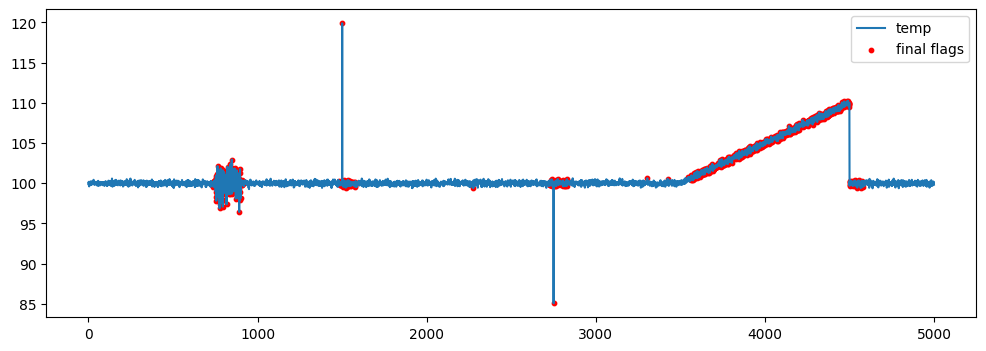

In [24]:

ts, ys = np.array(times), np.array(temps)

plt.figure()
plt.plot(ts, ys, label="temp")
plt.scatter(ts[np.array(flags_final)==1], ys[np.array(flags_final)==1], s=10, label="final flags", color="red")
plt.legend(); plt.show()


In [25]:

out = pd.DataFrame({
    "t": ts,
    "temp": ys,
    "flag_rule": flags_rule,
    "flag_slope": flags_slope,
    "flag_jitter": flags_jitter,
    "flag_iforest": flags_iforest,
    "flag_final": flags_final,
    "is_anomaly": y_true_np
})
os.makedirs("../data/processed", exist_ok=True)
csv_path = "../data/processed/streaming_results.csv"
out.to_csv(csv_path, index=False)
csv_path


'../data/processed/streaming_results.csv'